Import library

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
import torch.optim as optim
from torchvision.transforms import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel

import pickle
import random

Setting hyperparameter

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 1e-3

Loading pretrained KoGPT model

In [3]:
tokenizer = AutoTokenizer.from_pretrained(
  'kakaobrain/kogpt', revision='KoGPT6B-ryan1.5b-float16',  # or float32 version: revision=KoGPT6B-ryan1.5b
  bos_token='[BOS]', eos_token='[EOS]', unk_token='[UNK]', pad_token='[PAD]', mask_token='[MASK]'
)

model = AutoModel.from_pretrained(
  'kakaobrain/kogpt', revision='KoGPT6B-ryan1.5b-float16',  # or float32 version: revision=KoGPT6B-ryan1.5b
  pad_token_id=tokenizer.eos_token_id,
  torch_dtype='auto', low_cpu_mem_usage=True, output_hidden_states = True
).to(device='cuda', non_blocking=True)

_ = model.eval()
_ = model.requires_grad_(False)

GPTJModel(
  (wte): Embedding(64512, 4096)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0): GPTJBlock(
      (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
      (attn): GPTJAttention(
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.0, inplace=False)
        (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
        (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
        (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
        (out_proj): Linear(in_features=4096, out_features=4096, bias=False)
      )
      (mlp): GPTJMLP(
        (fc_in): Linear(in_features=4096, out_features=16384, bias=True)
        (fc_out): Linear(in_features=16384, out_features=4096, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (1): GPTJBlock(
      (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
      (attn): GPTJAttention(
        (attn_d

Declare model

In [4]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 12)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = torch.sigmoid(x) * 10
        return x

Load dataset

In [19]:
with open('sool_data.p', 'rb') as file: 
    sool_data = pickle.load(file)

taste_list = []
for i in sool_data:
    taste_list.append([x for _, x in i['taste'].items()])
taste_matrix = torch.tensor(taste_list).to(device).float()
taste_matrix = (taste_matrix - taste_matrix.mean(dim=0)) / taste_matrix.std(dim=0) + 5

data_list = []
for idx, i in enumerate(sool_data):
    if idx >= 100:
        break
    s = i['content'].split('\n')
    for j in s:
        if j == '':
            continue
        ss = j.split('.')
        for k in ss:
            if k == '' or k == ' ':
                continue
            data_list.append( (idx, k) )

validate_list = []
for idx, i in enumerate(sool_data):
    if idx < 100:
        continue
    s = i['content'].split('\n')
    for j in s:
        if j == '':
            continue
        ss = j.split('.')
        for k in ss:
            if k == '' or k == ' ':
                continue
            validate_list.append( (idx, k) )

Split data training and test

In [6]:
data_preset = []
for i in data_list:
    t = tokenizer.encode(i[1], return_tensors='pt').to(device)
    v = model(t).last_hidden_state[:, -1, :].float().view(-1, 1, 4096)
    data_preset.append( (i[0], v) )

val_preset = []
for i in validate_list:
    t = tokenizer.encode(i[1], return_tensors='pt').to(device)
    v = model(t).last_hidden_state[:, -1, :].float().view(-1, 1, 4096)
    val_preset.append( (i[0], v) )

Make dataset

In [7]:
class TextDataSet(torch.utils.data.Dataset): 
  def __init__(self, data):
      self.data = data
  def __len__(self):
      return len(self.data)
  def __getitem__(self, idx):
      x = self.data[idx][1].squeeze()
      y = taste_matrix[self.data[idx][0]]
      return x, y

learnData = TextDataSet(data_preset)
valData = TextDataSet(val_preset)


learnLoader = DataLoader(learnData, batch_size = 50, shuffle = True)
valLoader = DataLoader(valData, batch_size=1, shuffle=True)

Train model

0th epoch starting.
5th epoch starting.
10th epoch starting.
15th epoch starting.
20th epoch starting.
25th epoch starting.
30th epoch starting.
35th epoch starting.
40th epoch starting.
45th epoch starting.


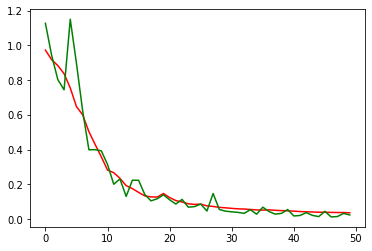

In [10]:
m = Classifier().to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(m.parameters(), lr=lr)

train_loss_list = []
val_loss_list = []
epochs = 50
for epoch in range(epochs) :
    m.train()
    if(epoch % 5 == 0):
        print(f"{epoch}th epoch starting.")

    train_loss_lists = []
    for x, y in learnLoader:
        l = m(x)
        optimizer.zero_grad()
        train_loss = loss_function(l, y)
        train_loss.backward()
        train_loss_lists.append(train_loss.item())

        optimizer.step()
    train_loss_list.append(sum(train_loss_lists) / len(train_loss_lists))

    m.eval()

    val_loss_lists = []
    for x, y in valLoader:
        with torch.no_grad():
            l = m(x)
        val_loss = torch.abs(l - y).mean()

        val_loss_lists.append(train_loss.item())
    val_loss_list.append(sum(val_loss_lists) / len(val_loss_lists))

plt.plot(list(range(epochs)), train_loss_list, 'r')
plt.plot(list(range(epochs)), val_loss_list, 'g')

plt.show()

Save model

In [18]:
# torch.save(m.state_dict(), 'full_model_test_2.p')